Now after we cleaned our data, lets proceed with Uploading it, then run some checks and further validates its integrity

In [1]:
library(tidyverse)
library(dplyr)
library(data.table)
library(ggplot2)
library(lubridate)
library(stringr)
library(corrplot)
library(knitr)
library(scales)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


corrplot 0.92 loaded


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object 

In [2]:
rides <- read.csv("/kaggle/input/bike-rides-dataset/Final trips table.csv")

In [3]:
sum(is.na(rides))

[1] 0

In [4]:
summary(rides)

   ride_id           user_type         start_station_id end_station_id 
 Length:3876054     Length:3876054     Min.   :  1.0    Min.   :  1.0  
 Class :character   Class :character   1st Qu.: 77.0    1st Qu.: 77.0  
 Mode  :character   Mode  :character   Median :174.0    Median :174.0  
                                       Mean   :202.4    Mean   :203.3  
                                       3rd Qu.:290.0    3rd Qu.:291.0  
                                       Max.   :673.0    Max.   :673.0  
 trip_duration      start_date         start_time          end_date        
 Min.   :      1   Length:3876054     Length:3876054     Length:3876054    
 1st Qu.:    411   Class :character   Class :character   Class :character  
 Median :    712   Mode  :character   Mode  :character   Mode  :character  
 Mean   :   1479                                                           
 3rd Qu.:   1289                                                           
 Max.   :9387024                        

In [5]:
head(rides)

,ride_id,user_type,start_station_id,end_station_id,trip_duration,start_date,start_time,end_date,end_time,weekend_or,holiday_or,weekday_name,season
,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,25309981,casual,171,32,598,2019-10-07,02:24:09,2019-10-07,02:34:07,weekday,not_holiday,Monday,Fall
2,25326097,casual,41,108,621,2019-10-07,19:15:19,2019-10-07,19:25:40,weekday,not_holiday,Monday,Fall
3,25315602,casual,256,115,607,2019-10-07,11:45:27,2019-10-07,11:55:34,weekday,not_holiday,Monday,Fall
4,25315330,casual,414,75,421,2019-10-07,11:21:00,2019-10-07,11:28:01,weekday,not_holiday,Monday,Fall
5,25315917,casual,116,224,1450,2019-10-07,12:12:06,2019-10-07,12:36:16,weekday,not_holiday,Monday,Fall
6,25324471,casual,18,212,285,2019-10-07,18:12:47,2019-10-07,18:17:33,weekday,not_holiday,Monday,Fall


Interestingly, the average duration is high, which could suggest the presence of outliers—extremely long durations that are skewing the average. Before making any decisions on how to handle this, further examination is needed. To start, let's sort the trip_duration column in descending order.

In [6]:
sorted_rides <- rides %>% arrange(desc(trip_duration))
head(sorted_rides, 10)

,ride_id,user_type,start_station_id,end_station_id,trip_duration,start_date,start_time,end_date,end_time,weekend_or,holiday_or,weekday_name,season
,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,279F7DB076FD4444,casual,270,355,9387024,2020-01-09,21:00:22,2020-04-27,12:30:46,weekday,not_holiday,Thursday,Winter
2,23798837,member,418,671,9056633,2019-07-16,18:17:58,2019-10-29,14:01:52,weekday,not_holiday,Tuesday,Summer
3,377B59F0A27BB4CB,casual,503,29,8636205,2020-02-02,17:18:57,2020-05-12,16:15:42,weekend,not_holiday,Sunday,Winter
4,25302386,casual,435,671,8585902,2019-10-06,13:57:02,2020-01-13,21:55:24,weekend,not_holiday,Sunday,Fall
5,23889502,member,451,671,8203637,2019-07-22,12:09:36,2019-10-25,10:56:54,weekday,not_holiday,Monday,Summer
6,25487192,casual,529,671,8120385,2019-10-19,15:14:50,2020-01-21,13:54:35,weekend,not_holiday,Saturday,Fall
7,23710210,casual,317,671,7939448,2019-07-12,13:08:10,2019-10-12,10:32:18,weekday,not_holiday,Friday,Summer
8,24107150,casual,161,592,7667469,2019-08-01,18:45:47,2019-10-29,12:36:57,weekday,not_holiday,Thursday,Summer
9,23661214,casual,71,117,7606871,2019-07-10,10:25:13,2019-10-06,11:26:25,weekday,not_holiday,Wednesday,Summer


In [7]:
# Summarize rides by user type including median duration
user_duration_summary <- rides %>%
  group_by(user_type) %>%
  summarise(
    total_rides = n(),
    min_duration = min(trip_duration, na.rm = TRUE),
    max_duration = max(trip_duration, na.rm = TRUE),
    median_duration = median(trip_duration, na.rm = TRUE),
    mean_duration = mean(trip_duration, na.rm = TRUE),
    stddev_duration = sd(trip_duration, na.rm = TRUE)
  )
kable(user_duration_summary)



|user_type | total_rides| min_duration| max_duration| median_duration| mean_duration| stddev_duration|
|:---------|-----------:|------------:|------------:|---------------:|-------------:|---------------:|
|casual    |      902188|            2|      9387024|            1546|     3552.5785|        58417.34|
|member    |     2973866|            1|      9056633|             589|      849.7217|        14478.13|

It may be tempting to remove the outliers; however, it appears that there may be a trend for each user type. In this case, I propose bucketing or segmenting the duration into intervals and counting how many rides fall within each interval, then grouping them by user type.

I'll begin by creating categories for duration, breaking the trip duration into segments.


In [8]:
# Convert and extract the hour from the start_time
rides$start_time <- as.POSIXct(rides$start_time, format="%H:%M:%S")
rides$hour_of_day <- format(rides$start_time, "%H")
View(rides)

# Create duration categories
rides$duration_category <- cut(
  rides$trip_duration,
  breaks = c(0, 60, 300, 1800, 3600, 7200, 21600, 43200, 86400, 604800, 2592000, Inf),
  labels = c("0-1 min", "1-5 min", "5-30 min", "30 min - 1 hr", "1-2 hrs", "2-6 hrs", "6-12 hrs", "12-24 hrs", "1-7 days", "7-30 days", "> 30 days"),
  right = FALSE
)

# Summarize the number of rides by duration category and user type
ride_duration_counts <- rides %>%
  group_by(duration_category, user_type) %>%
  summarise(num_rides = n())
kable(ride_duration_counts, n = Inf)

ride_id,user_type,start_station_id,end_station_id,trip_duration,start_date,start_time,end_date,end_time,weekend_or,holiday_or,weekday_name,season,hour_of_day
<chr>,<chr>,<int>,<int>,<int>,<chr>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
25309981,casual,171,32,598,2019-10-07,2023-09-27 02:24:09,2019-10-07,02:34:07,weekday,not_holiday,Monday,Fall,02
25326097,casual,41,108,621,2019-10-07,2023-09-27 19:15:19,2019-10-07,19:25:40,weekday,not_holiday,Monday,Fall,19
25315602,casual,256,115,607,2019-10-07,2023-09-27 11:45:27,2019-10-07,11:55:34,weekday,not_holiday,Monday,Fall,11
25315330,casual,414,75,421,2019-10-07,2023-09-27 11:21:00,2019-10-07,11:28:01,weekday,not_holiday,Monday,Fall,11
25315917,casual,116,224,1450,2019-10-07,2023-09-27 12:12:06,2019-10-07,12:36:16,weekday,not_holiday,Monday,Fall,12
25324471,casual,18,212,285,2019-10-07,2023-09-27 18:12:47,2019-10-07,18:17:33,weekday,not_holiday,Monday,Fall,18
25315195,casual,35,43,1231,2019-10-07,2023-09-27 11:06:10,2019-10-07,11:26:41,weekday,not_holiday,Monday,Fall,11
25318318,casual,199,672,300,2019-10-07,2023-09-27 15:15:30,2019-10-07,15:20:31,weekday,not_holiday,Monday,Fall,15
25317947,casual,341,623,1864,2019-10-07,2023-09-27 14:48:23,2019-10-07,15:19:28,weekday,not_holiday,Monday,Fall,14


`summarise()` has grouped output by 'duration_category'. You can override using
the `.groups` argument.




|duration_category |user_type | num_rides|
|:-----------------|:---------|---------:|
|0-1 min           |casual    |       189|
|0-1 min           |member    |      3719|
|1-5 min           |casual    |     19456|
|1-5 min           |member    |    509726|
|5-30 min          |casual    |    513399|
|5-30 min          |member    |   2288578|
|30 min - 1 hr     |casual    |    220127|
|30 min - 1 hr     |member    |    159852|
|1-2 hrs           |casual    |    109038|
|1-2 hrs           |member    |      8416|
|2-6 hrs           |casual    |     35045|
|2-6 hrs           |member    |      1958|
|6-12 hrs          |casual    |      1796|
|6-12 hrs          |member    |       584|
|12-24 hrs         |casual    |      1631|
|12-24 hrs         |member    |       594|
|1-7 days          |casual    |      1116|
|1-7 days          |member    |       376|
|7-30 days         |casual    |       279|
|7-30 days         |member    |        44|
|> 30 days         |casual    |       112|
|> 30 day

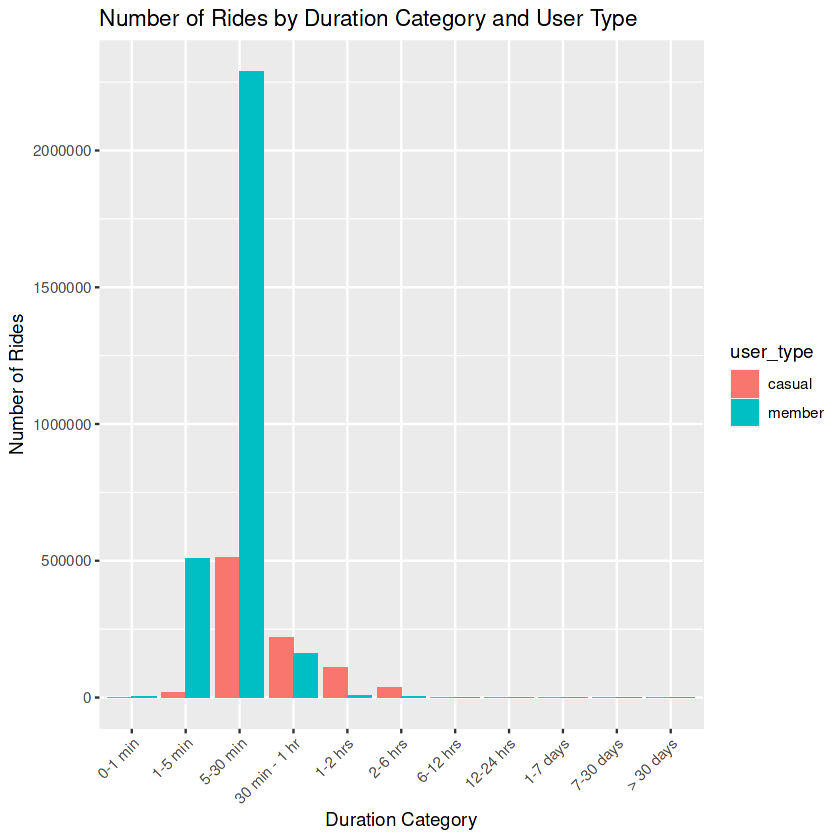

In [9]:
# Visualizing the number of rides by duration category and user type
ggplot(ride_duration_counts, aes(x = duration_category, y = num_rides, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Number of Rides by Duration Category and User Type",
       x = "Duration Category",
       y = "Number of Rides") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [10]:
# Summarize rides by duration category and user type with additional statistics
ride_duration_stats <- rides %>%
  group_by(duration_category, user_type) %>%
  summarise(
    num_rides = n(),
    min_duration = min(trip_duration, na.rm = TRUE),
    max_duration = max(trip_duration, na.rm = TRUE),
    mean_duration = mean(trip_duration, na.rm = TRUE),
    median_duration = median(trip_duration, na.rm = TRUE)
  )
kable(ride_duration_stats, n = Inf)

`summarise()` has grouped output by 'duration_category'. You can override using
the `.groups` argument.




|duration_category |user_type | num_rides| min_duration| max_duration| mean_duration| median_duration|
|:-----------------|:---------|---------:|------------:|------------:|-------------:|---------------:|
|0-1 min           |casual    |       189|            2|           59|  2.935450e+01|            26.0|
|0-1 min           |member    |      3719|            1|           59|  2.103415e+01|            17.0|
|1-5 min           |casual    |     19456|           61|          299|  2.154139e+02|           231.0|
|1-5 min           |member    |    509726|           60|          299|  2.184684e+02|           226.0|
|5-30 min          |casual    |    513399|          300|         1799|  1.056559e+03|          1046.0|
|5-30 min          |member    |   2288578|          300|         1799|  7.544096e+02|           655.0|
|30 min - 1 hr     |casual    |    220127|         1800|         3599|  2.512149e+03|          2418.0|
|30 min - 1 hr     |member    |    159852|         1800|         3599| 

In [11]:
# Reshape the data for plotting
ride_duration_stats_melted <- gather(ride_duration_stats, key = "Statistic", value = "Value", -duration_category, -user_type, -num_rides)


Warning message in geom_point(aes(linetype = Statistic), linewidth = 1):
“Ignoring unknown parameters: `linewidth`”
Warning message in geom_point(aes(linetype = Statistic), linewidth = 1):
“Ignoring unknown aesthetics: linetype”


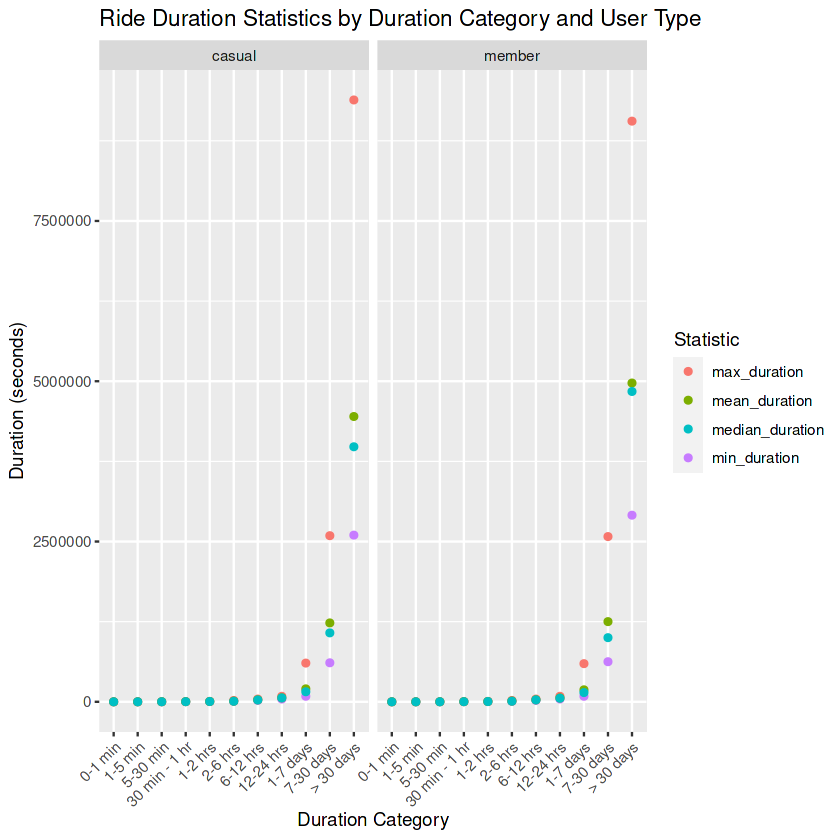

In [12]:
# Plotting the statistics
ggplot(ride_duration_stats_melted, aes(x = duration_category, y = Value, color = Statistic, group = interaction(Statistic, duration_category))) +
  geom_point(aes(linetype = Statistic), linewidth = 1) + 
  facet_wrap(~ user_type) +
  labs(title = "Ride Duration Statistics by Duration Category and User Type",
       x = "Duration Category",
       y = "Duration (seconds)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

As we can see, after segmenting the number of rides by duration, a significant difference in user type behavior emerges concerning the duration of the trip. Further analysis reveals that casual users tend to have trips lasting over 30 days nearly five times more often than member users. We can speculate that this may be due to one-time use and forgetting to properly return the bikes. Further investigation is needed.

Based on the initial Exploratory Data Analysis (EDA) and Descriptive Analysis, we start to notice distinct behavior patterns between the two user types. Casual members tend to have fewer rides (as expected) but of longer duration, in contrast to member users, who tend to have more frequent rides but of shorter duration.

The question now arises: do casual members tend to have more leisure rides compared to members? To answer this, we need to analyze differences in user behavior based on various factors such as weekends versus weekdays, hourly patterns, daily patterns, seasonal variations, and holidays. Additionally, let's examine the rate at which users return to the same station.

In [13]:
#New column indicating if the ride returned to the same station
rides$return_same_station <- ifelse(rides$start_station_id == rides$end_station_id, "Yes", "No")

#Overall number of same station return or no by User Type
same_station_by_user <- rides %>%
  group_by(user_type, return_same_station) %>%
  summarise(total_rides = n())
kable(same_station_by_user)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |return_same_station | total_rides|
|:---------|:-------------------|-----------:|
|casual    |No                  |      793959|
|casual    |Yes                 |      108229|
|member    |No                  |     2920414|
|member    |Yes                 |       53452|

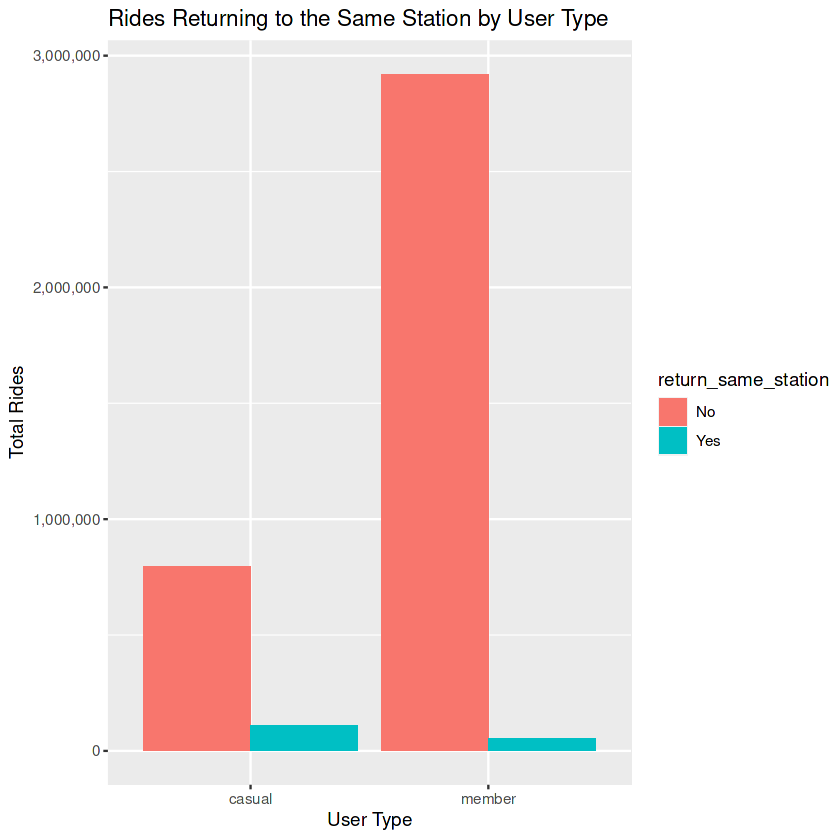

In [14]:
#Plotting the Trend of returned to same station
ggplot(same_station_by_user, aes(x = user_type, y = total_rides, fill = return_same_station)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Rides Returning to the Same Station by User Type",
       x = "User Type",
       y = "Total Rides") +
  scale_y_continuous(labels = scales::comma)

**Rides By Hour of the Day:**

In [15]:
# Summarize the overall peak usage time by hour of the day
overall_peak_time <- rides %>%
  group_by(hour_of_day) %>%
  summarise(total_rides = n())
kable(overall_peak_time)



|hour_of_day | total_rides|
|:-----------|-----------:|
|00          |       24112|
|01          |       14475|
|02          |        8591|
|03          |        5528|
|04          |        7882|
|05          |       37133|
|06          |      110385|
|07          |      242904|
|08          |      310468|
|09          |      166126|
|10          |      147662|
|11          |      183654|
|12          |      211175|
|13          |      212642|
|14          |      211638|
|15          |      249029|
|16          |      381232|
|17          |      478086|
|18          |      317530|
|19          |      210437|
|20          |      135057|
|21          |       97296|
|22          |       70221|
|23          |       42791|

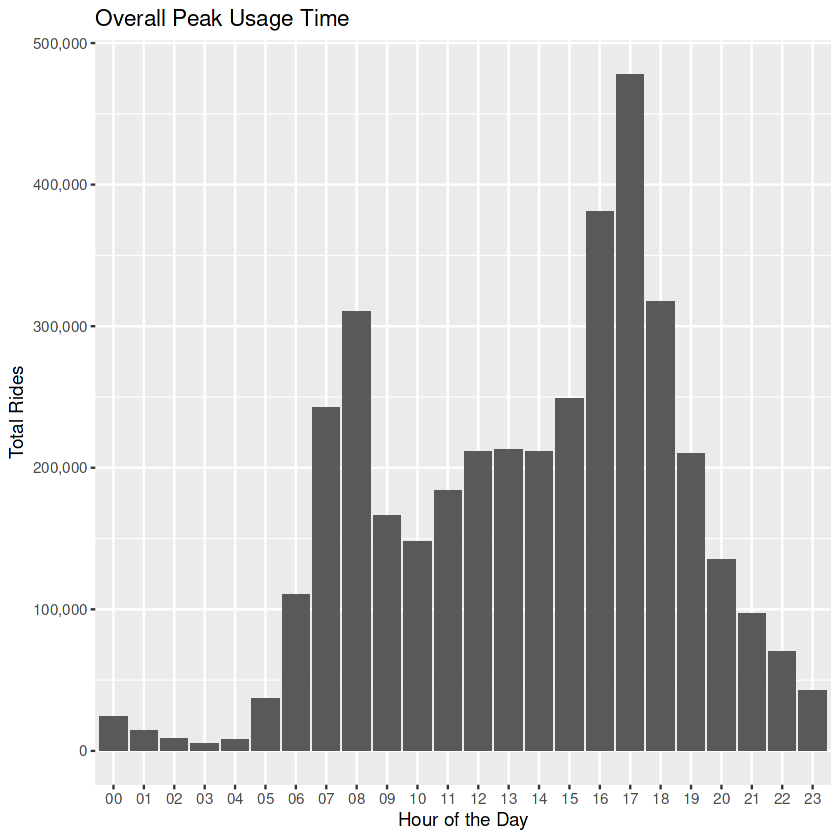

In [16]:
# Plotting the Overall Trend
ggplot(overall_peak_time, aes(x = hour_of_day, y = total_rides)) +
  geom_bar(stat = "identity") +
  labs(title = "Overall Peak Usage Time",
       x = "Hour of the Day",
       y = "Total Rides") +
scale_y_continuous(labels = scales::comma)

In [17]:
# Trends by User Type for Peak Usage Time
user_peak_time <- rides %>%
  group_by(hour_of_day, user_type) %>%
  summarise(total_rides = n()) %>%
  arrange(hour_of_day, user_type)
kable(user_peak_time)

`summarise()` has grouped output by 'hour_of_day'. You can override using the
`.groups` argument.




|hour_of_day |user_type | total_rides|
|:-----------|:---------|-----------:|
|00          |casual    |        8363|
|00          |member    |       15749|
|01          |casual    |        5501|
|01          |member    |        8974|
|02          |casual    |        3361|
|02          |member    |        5230|
|03          |casual    |        1982|
|03          |member    |        3546|
|04          |casual    |        1196|
|04          |member    |        6686|
|05          |casual    |        2690|
|05          |member    |       34443|
|06          |casual    |        6291|
|06          |member    |      104094|
|07          |casual    |       13302|
|07          |member    |      229602|
|08          |casual    |       22304|
|08          |member    |      288164|
|09          |casual    |       29057|
|09          |member    |      137069|
|10          |casual    |       45374|
|10          |member    |      102288|
|11          |casual    |       61323|
|11          |member   

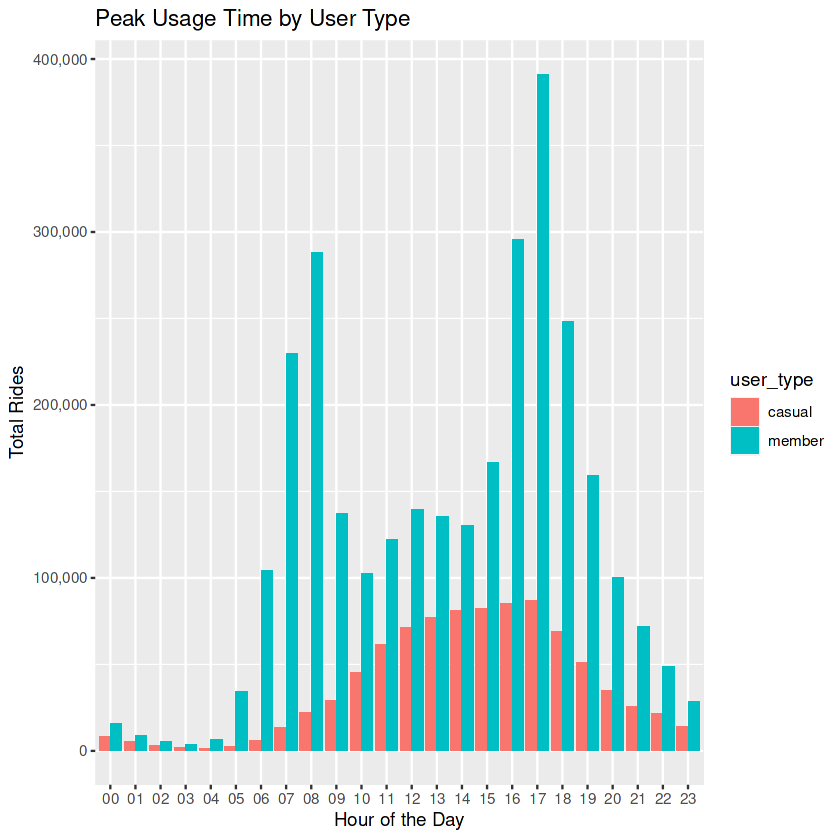

In [18]:
# Plotting the Trends by User Type
ggplot(user_peak_time, aes(x = hour_of_day, y = total_rides, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Peak Usage Time by User Type",
       x = "Hour of the Day",
       y = "Total Rides") +
scale_y_continuous(labels = scales::comma)

In [19]:
# Total Rides and Trip Duration Statistics by Hour of the Day
rides_by_hour_and_stats <- rides %>%
  group_by(user_type,hour_of_day) %>%
  summarise(
    total_rides = n(),
    min_duration = min(trip_duration, na.rm = TRUE),
    max_duration = max(trip_duration, na.rm = TRUE),
    median_duration = median(trip_duration, na.rm = TRUE),
    mean_duration = mean(trip_duration, na.rm = TRUE),
    stddev_duration = sd(trip_duration, na.rm = TRUE)
  )
kable(rides_by_hour_and_stats)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |hour_of_day | total_rides| min_duration| max_duration| median_duration| mean_duration| stddev_duration|
|:---------|:-----------|-----------:|------------:|------------:|---------------:|-------------:|---------------:|
|casual    |00          |        8363|           64|      6419224|          1303.0|     6256.3352|      117731.040|
|casual    |01          |        5501|           65|      4015949|          1354.0|     6224.9376|       93341.231|
|casual    |02          |        3361|           72|      4314650|          1258.0|     6232.0678|       96981.837|
|casual    |03          |        1982|           69|      3736093|          1237.5|    10215.0040|      136540.553|
|casual    |04          |        1196|          119|      3939702|          1050.5|     7591.6756|      116868.056|
|casual    |05          |        2690|           61|      6940545|           889.5|     5940.7361|      140624.217|
|casual    |06          |        6291|            8|      5470866|    

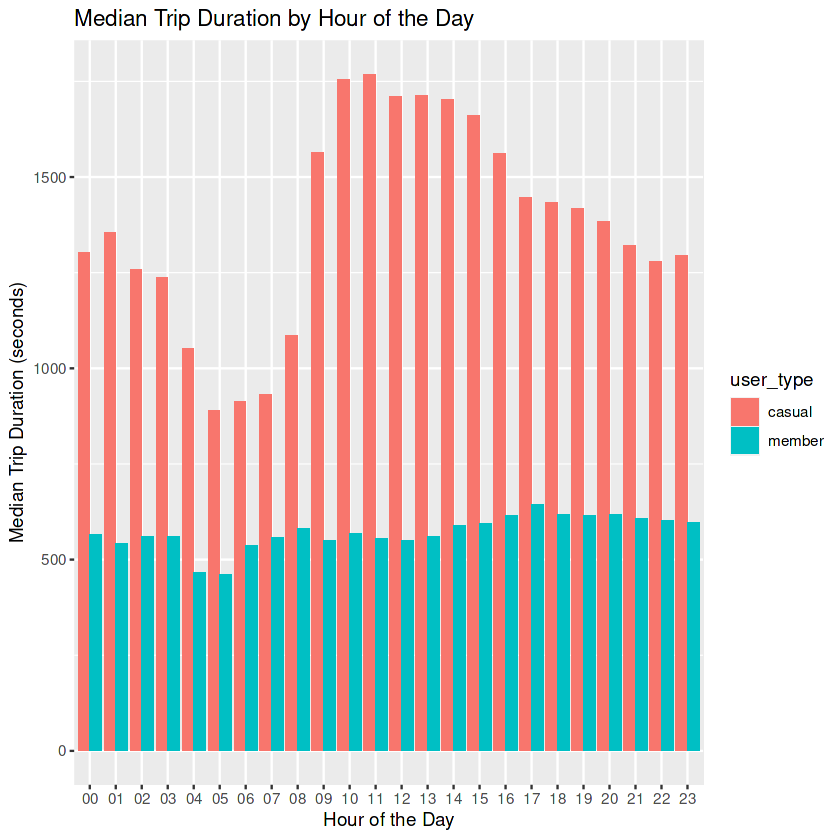

In [20]:
#Plotting Time based Analysis
ggplot(rides_by_hour_and_stats, aes(x = hour_of_day, y = median_duration, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Median Trip Duration by Hour of the Day",
       x = "Hour of the Day",
       y = "Median Trip Duration (seconds)")

In [21]:
#Same station Time based Analysis
same_station_by_hour <- rides %>%
  group_by(user_type, hour_of_day, return_same_station) %>%
  summarise(total_rides = n())
kable(same_station_by_hour)

`summarise()` has grouped output by 'user_type', 'hour_of_day'. You can
override using the `.groups` argument.




|user_type |hour_of_day |return_same_station | total_rides|
|:---------|:-----------|:-------------------|-----------:|
|casual    |00          |No                  |        6709|
|casual    |00          |Yes                 |        1654|
|casual    |01          |No                  |        4343|
|casual    |01          |Yes                 |        1158|
|casual    |02          |No                  |        2757|
|casual    |02          |Yes                 |         604|
|casual    |03          |No                  |        1685|
|casual    |03          |Yes                 |         297|
|casual    |04          |No                  |        1020|
|casual    |04          |Yes                 |         176|
|casual    |05          |No                  |        2340|
|casual    |05          |Yes                 |         350|
|casual    |06          |No                  |        5484|
|casual    |06          |Yes                 |         807|
|casual    |07          |No           

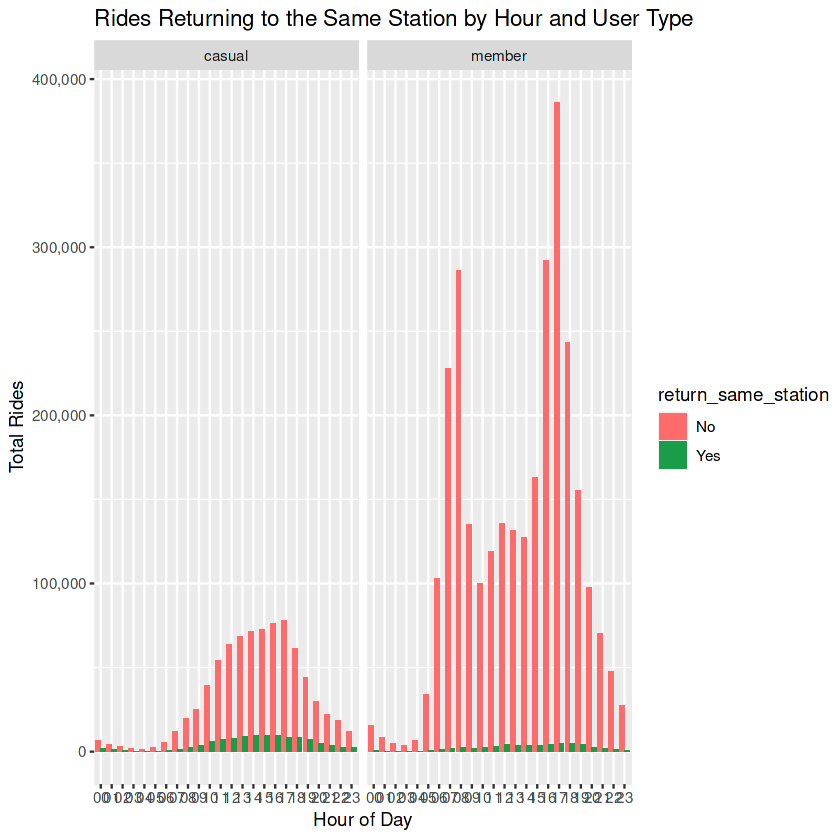

In [22]:
#Plotting Same station Time based Analysis
ggplot(same_station_by_hour, aes(x = hour_of_day, y = total_rides, fill = return_same_station)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ user_type) +
  labs(title = "Rides Returning to the Same Station by Hour and User Type",
       x = "Hour of Day",
       y = "Total Rides") +
  scale_fill_manual(values = c("Yes" = "#1a9d49", "No" = "#ff6b6b")) +
  scale_y_continuous(labels = scales::comma)

**Analysis By season**

In [23]:
# Summarize total rides by season
rides_by_season <- rides %>%
  group_by(season) %>%
  summarise(total_rides = n())
kable(rides_by_season)



|season | total_rides|
|:------|-----------:|
|Fall   |     1042181|
|Spring |      772975|
|Summer |     1622894|
|Winter |      438004|

In [24]:
# Trends by User Type for Seasonal Usage
user_seasonal <- rides %>%
  group_by(user_type, season) %>%
  summarise(total_rides = n())
kable(user_seasonal)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |season | total_rides|
|:---------|:------|-----------:|
|casual    |Fall   |      218937|
|casual    |Spring |      153983|
|casual    |Summer |      492739|
|casual    |Winter |       36529|
|member    |Fall   |      823244|
|member    |Spring |      618992|
|member    |Summer |     1130155|
|member    |Winter |      401475|

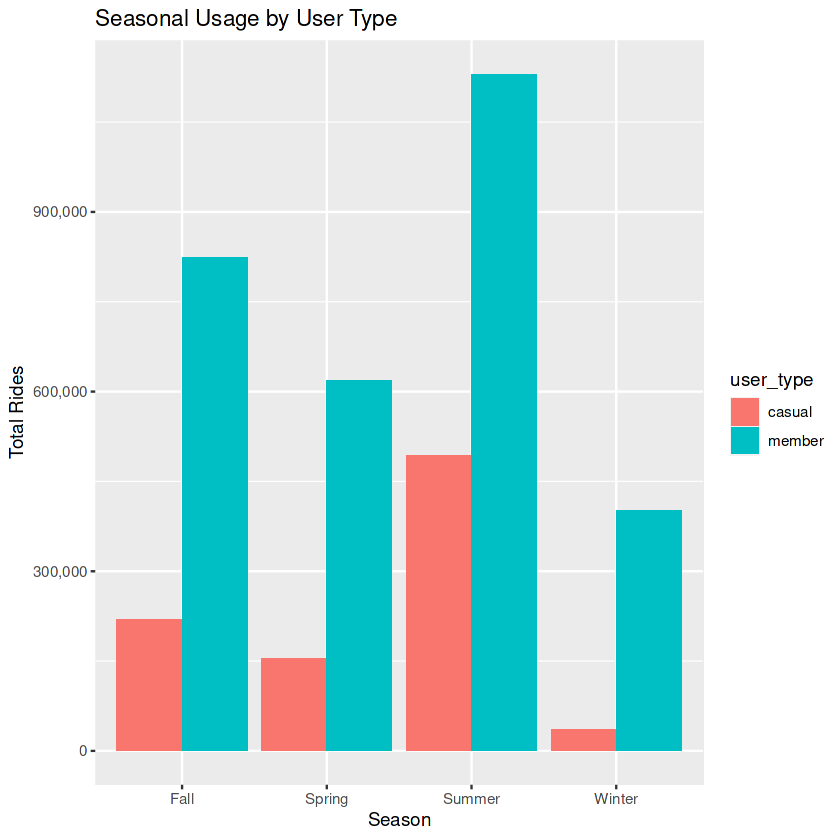

In [25]:
# Plotting the Trends by User Type
ggplot(user_seasonal, aes(x = season, y = total_rides, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Seasonal Usage by User Type",
       x = "Season",
       y = "Total Rides") +
  scale_y_continuous(labels = scales::comma)

In [26]:
# Total Rides and Trip Duration Statistics by Season
rides_by_season_and_stats <- rides %>%
  group_by(user_type,season) %>%
  summarise(
    total_rides = n(),
    min_duration = min(trip_duration, na.rm = TRUE),
    max_duration = max(trip_duration, na.rm = TRUE),
    median_duration = median(trip_duration, na.rm = TRUE),
    mean_duration = mean(trip_duration, na.rm = TRUE),
    stddev_duration = sd(trip_duration, na.rm = TRUE)
  )
kable(rides_by_season_and_stats)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |season | total_rides| min_duration| max_duration| median_duration| mean_duration| stddev_duration|
|:---------|:------|-----------:|------------:|------------:|---------------:|-------------:|---------------:|
|casual    |Fall   |      218937|           61|      8585902|            1395|     3321.5181|       51875.415|
|casual    |Spring |      153983|            3|      4757640|            1657|     3256.7740|       34206.640|
|casual    |Summer |      492739|           61|      7939448|            1598|     3531.2691|       60814.421|
|casual    |Winter |       36529|            2|      9387024|            1225|     6471.8079|      115438.166|
|member    |Fall   |      823244|           61|      5169622|             567|      803.6614|       11032.546|
|member    |Spring |      618992|            1|      5627611|             582|      828.9518|       10686.909|
|member    |Summer |     1130155|           61|      9056633|             650|      945.8206|       19106.181|

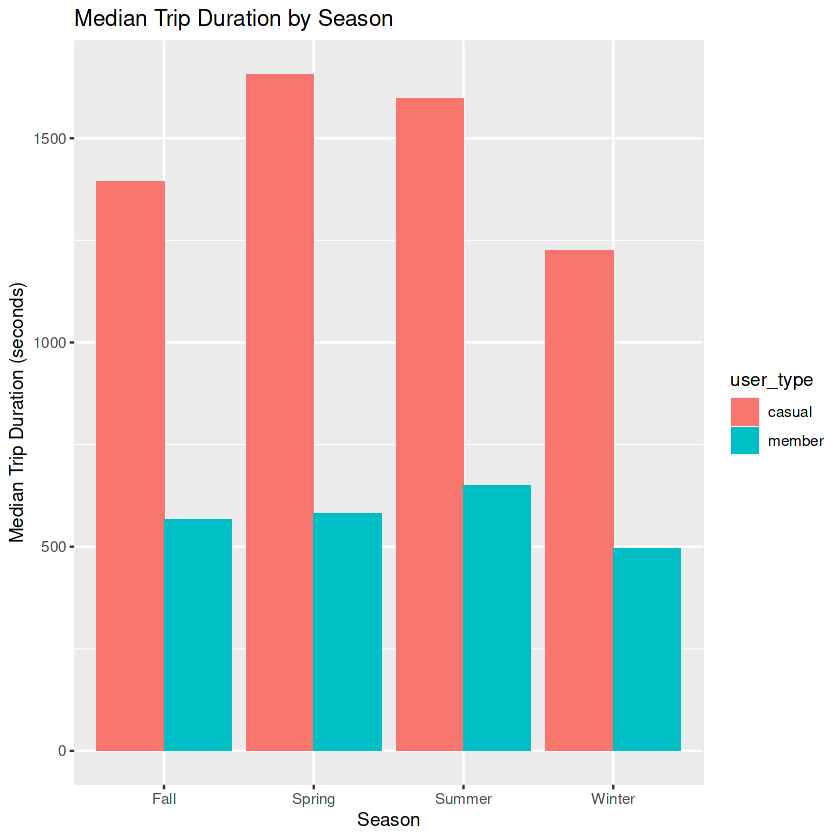

In [27]:
#Plotting Trip Duration by Season
ggplot(rides_by_season_and_stats, aes(x = season, y = median_duration, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Median Trip Duration by Season",
       x = "Season",
       y = "Median Trip Duration (seconds)")

In [28]:
#Same station Seasonal Analysis
same_station_by_season <- rides %>%
  group_by(user_type, season, return_same_station) %>%
  summarise(total_rides = n())
kable(same_station_by_season)

`summarise()` has grouped output by 'user_type', 'season'. You can override
using the `.groups` argument.




|user_type |season |return_same_station | total_rides|
|:---------|:------|:-------------------|-----------:|
|casual    |Fall   |No                  |      197811|
|casual    |Fall   |Yes                 |       21126|
|casual    |Spring |No                  |      131588|
|casual    |Spring |Yes                 |       22395|
|casual    |Summer |No                  |      432317|
|casual    |Summer |Yes                 |       60422|
|casual    |Winter |No                  |       32243|
|casual    |Winter |Yes                 |        4286|
|member    |Fall   |No                  |      811563|
|member    |Fall   |Yes                 |       11681|
|member    |Spring |No                  |      605913|
|member    |Spring |Yes                 |       13079|
|member    |Summer |No                  |     1108473|
|member    |Summer |Yes                 |       21682|
|member    |Winter |No                  |      394465|
|member    |Winter |Yes                 |        7010|

List of 97
 $ line                      :List of 6
  ..$ colour       : chr "black"
  ..$ linewidth    : num 0.5
  ..$ linetype     : num 1
  ..$ lineend      : chr "butt"
  ..$ arrow        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_line" "element"
 $ rect                      :List of 5
  ..$ fill         : chr "white"
  ..$ colour       : chr "black"
  ..$ linewidth    : num 0.5
  ..$ linetype     : num 1
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_rect" "element"
 $ text                      :List of 11
  ..$ family       : chr ""
  ..$ face         : chr "plain"
  ..$ colour       : chr "black"
  ..$ size         : num 11
  ..$ hjust        : num 0.5
  ..$ vjust        : num 0.5
  ..$ angle        : num 0
  ..$ lineheight   : num 0.9
  ..$ margin       : 'margin' num [1:4] 0points 0points 0points 0points
  .. ..- attr(*, "unit")= int 8
  ..$ debug        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr

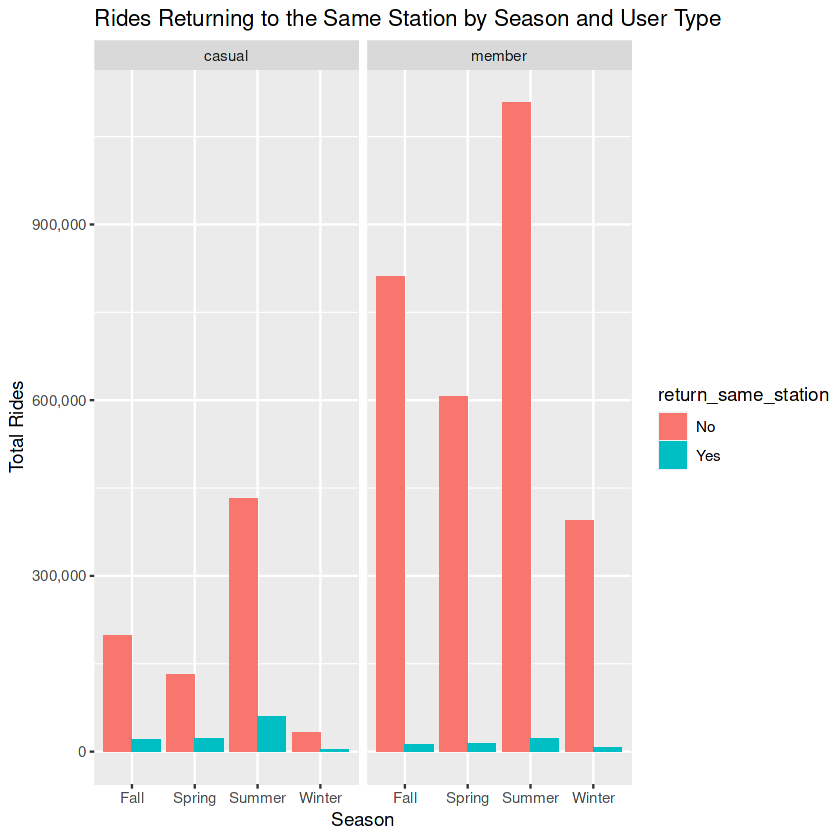

In [29]:
#Plotting Same station Seasonal
ggplot(same_station_by_season, aes(x = season, y = total_rides, fill = return_same_station)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ user_type) +
  labs(title = "Rides Returning to the Same Station by Season and User Type",
       x = "Season",
       y = "Total Rides") +
  scale_y_continuous(labels = scales::comma)
  theme_minimal()

**Weekend Weekday Analysis**

In [30]:
# Overall Trend for Weekday vs Weekend Usage
overall_weekday_weekend <- rides %>%
  group_by(weekend_or) %>%
  summarise(total_rides = n())
kable(overall_weekday_weekend)



|weekend_or | total_rides|
|:----------|-----------:|
|weekday    |     2929283|
|weekend    |      946771|

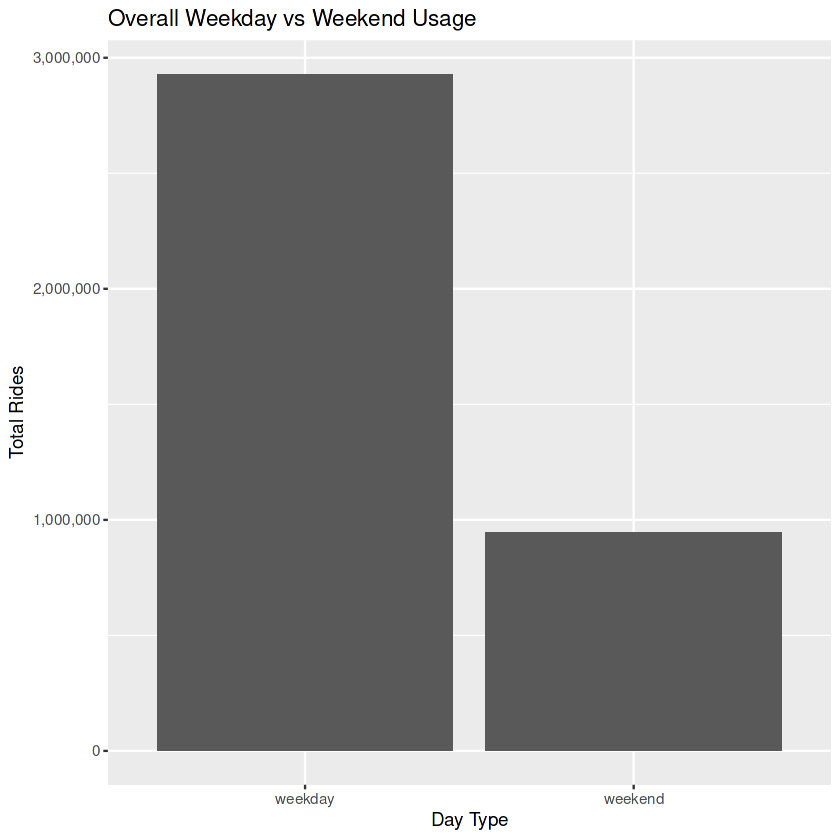

In [31]:
# Plotting the Overall Trend for Weekday vs Weekend Usage
ggplot(overall_weekday_weekend, aes(x = weekend_or, y = total_rides)) +
  geom_bar(stat = "identity") +
  labs(title = "Overall Weekday vs Weekend Usage",
       x = "Day Type",
       y = "Total Rides") +
  scale_y_continuous(labels = scales::comma)

In [32]:
# Trends by User Type for Weekday vs Weekend Usage
user_weekday_weekend <- rides %>%
  group_by(user_type, weekend_or) %>%
  summarise(total_rides = n())
kable(user_weekday_weekend)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |weekend_or | total_rides|
|:---------|:----------|-----------:|
|casual    |weekday    |      511346|
|casual    |weekend    |      390842|
|member    |weekday    |     2417937|
|member    |weekend    |      555929|

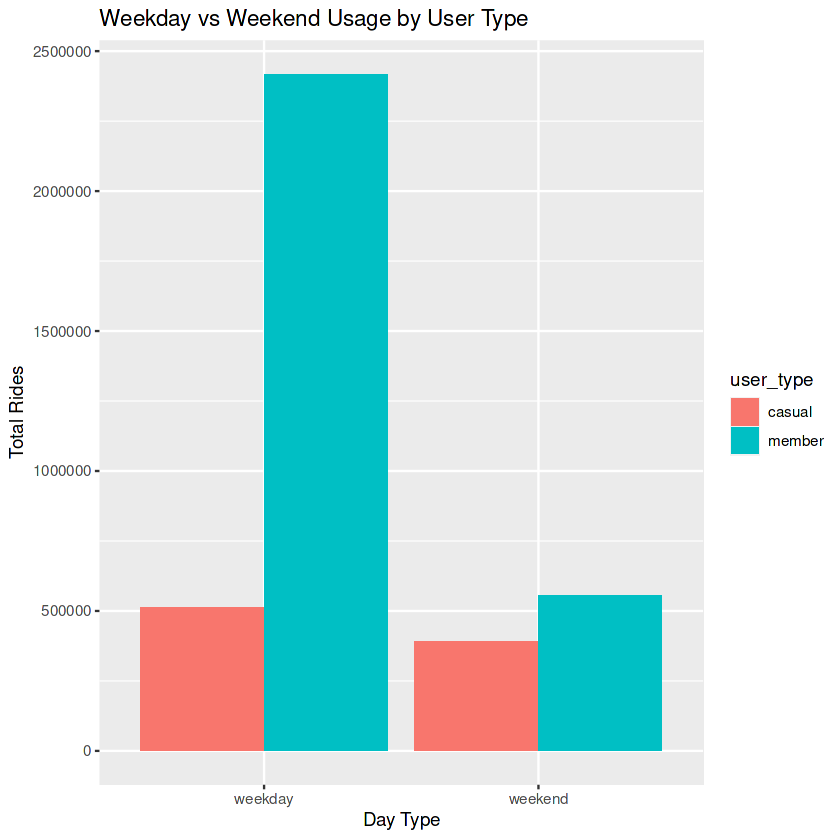

In [33]:
# Plotting the Trends by User Type for Weekday vs Weekend Usage
ggplot(user_weekday_weekend, aes(x = weekend_or, y = total_rides, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Weekday vs Weekend Usage by User Type",
       x = "Day Type",
       y = "Total Rides")

In [34]:
#Same station Weekend Weekday Analysis
same_station_by_weekday <- rides %>%
  group_by(user_type, weekend_or, return_same_station) %>%
  summarise(total_rides = n())
kable(same_station_by_weekday)

`summarise()` has grouped output by 'user_type', 'weekend_or'. You can override
using the `.groups` argument.




|user_type |weekend_or |return_same_station | total_rides|
|:---------|:----------|:-------------------|-----------:|
|casual    |weekday    |No                  |      451433|
|casual    |weekday    |Yes                 |       59913|
|casual    |weekend    |No                  |      342526|
|casual    |weekend    |Yes                 |       48316|
|member    |weekday    |No                  |     2381030|
|member    |weekday    |Yes                 |       36907|
|member    |weekend    |No                  |      539384|
|member    |weekend    |Yes                 |       16545|

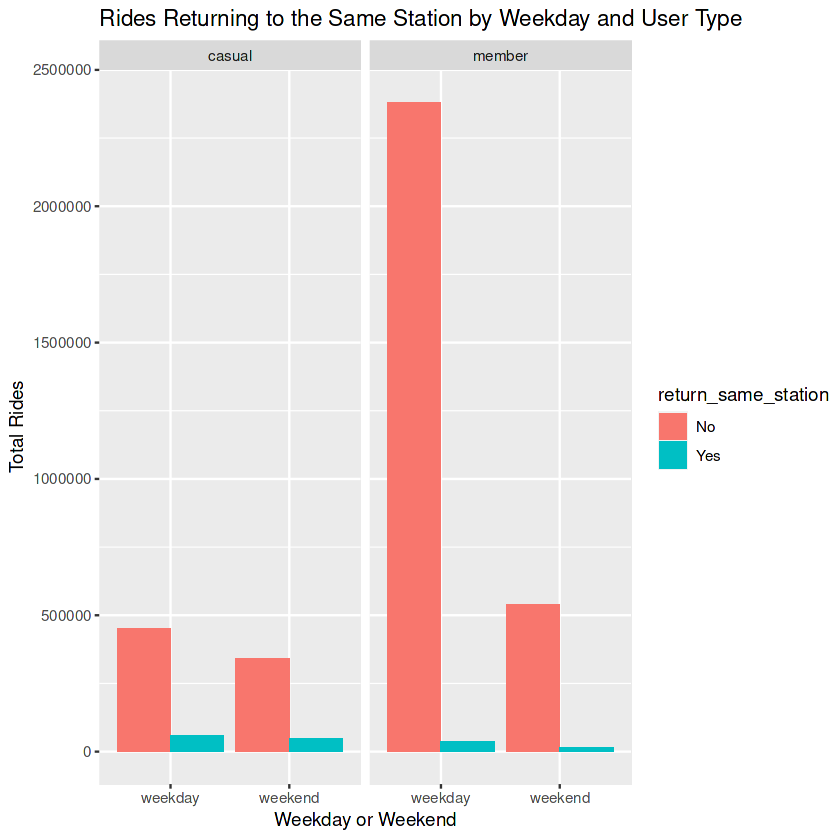

In [35]:
#plotting same station weekend weekday analysis
ggplot(same_station_by_weekday, aes(x = weekend_or, y = total_rides, fill = return_same_station)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ user_type) +
  labs(title = "Rides Returning to the Same Station by Weekday and User Type",
       x = "Weekday or Weekend",
       y = "Total Rides")

**Analysis By weekday**

In [36]:
# Summarize total rides by user type and weekday
rides_by_weekday <- rides %>%
  group_by(user_type, weekday_name) %>%
  summarise(total_rides = n()) %>%
  arrange(desc(total_rides))
kable(rides_by_weekday)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |weekday_name | total_rides|
|:---------|:------------|-----------:|
|member    |Tuesday      |      508445|
|member    |Wednesday    |      500329|
|member    |Thursday     |      484177|
|member    |Monday       |      472196|
|member    |Friday       |      452790|
|member    |Saturday     |      287958|
|member    |Sunday       |      267971|
|casual    |Saturday     |      209543|
|casual    |Sunday       |      181299|
|casual    |Friday       |      122404|
|casual    |Monday       |      103296|
|casual    |Thursday     |      102679|
|casual    |Wednesday    |       92457|
|casual    |Tuesday      |       90510|

In [37]:
# Total Rides and Trip Duration Statistics by Weekday and User Type
rides_by_weekday_and_stats <- rides %>%
  group_by(user_type, weekday_name) %>%
  summarise(
    total_rides = n(),
    min_duration = min(trip_duration, na.rm = TRUE),
    max_duration = max(trip_duration, na.rm = TRUE),
    median_duration = median(trip_duration, na.rm = TRUE),
    mean_duration = mean(trip_duration, na.rm = TRUE),
    stddev_duration = sd(trip_duration, na.rm = TRUE)
  )
kable(rides_by_weekday_and_stats)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |weekday_name | total_rides| min_duration| max_duration| median_duration| mean_duration| stddev_duration|
|:---------|:------------|-----------:|------------:|------------:|---------------:|-------------:|---------------:|
|casual    |Friday       |      122404|            2|      7939448|            1499|     3773.6518|       68607.953|
|casual    |Monday       |      103296|            8|      7247750|            1547|     3372.0315|       51815.715|
|casual    |Saturday     |      209543|            3|      8120385|            1658|     3331.8338|       43264.863|
|casual    |Sunday       |      181299|            3|      8636205|            1626|     3581.1876|       57676.879|
|casual    |Thursday     |      102679|           11|      9387024|            1430|     3682.7777|       66018.899|
|casual    |Tuesday      |       90510|           11|      7522062|            1427|     3596.1227|       60798.004|
|casual    |Wednesday    |       92457|            6|      760

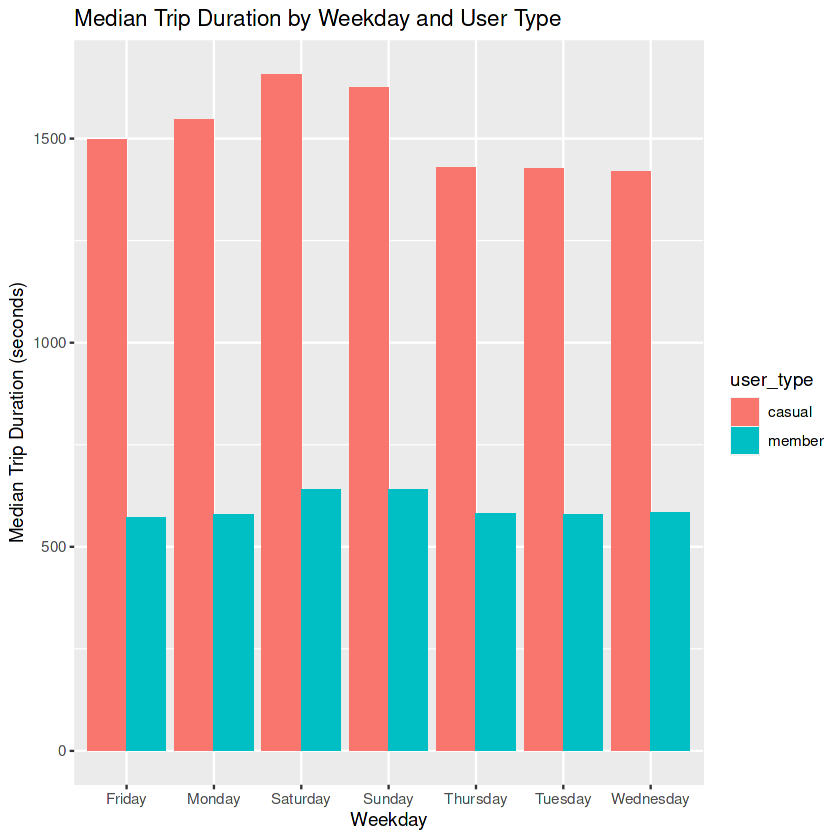

In [38]:
#Plotting Trip Duration by Weekday and User Type
ggplot(rides_by_weekday_and_stats, aes(x = weekday_name, y = median_duration, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Median Trip Duration by Weekday and User Type",
       x = "Weekday",
       y = "Median Trip Duration (seconds)")

`summarise()` has grouped output by 'weekday_name'. You can override using the
`.groups` argument.




|weekday_name |hour_of_day | total_rides|
|:------------|:-----------|-----------:|
|Friday       |00          |        3195|
|Friday       |01          |        1700|
|Friday       |02          |         978|
|Friday       |03          |         672|
|Friday       |04          |        1179|
|Friday       |05          |        6195|
|Friday       |06          |       18605|
|Friday       |07          |       41973|
|Friday       |08          |       52814|
|Friday       |09          |       24964|
|Friday       |10          |       19425|
|Friday       |11          |       24619|
|Friday       |12          |       29479|
|Friday       |13          |       30616|
|Friday       |14          |       31786|
|Friday       |15          |       40740|
|Friday       |16          |       62095|
|Friday       |17          |       65674|
|Friday       |18          |       41744|
|Friday       |19          |       27011|
|Friday       |20          |       17615|
|Friday       |21          |    

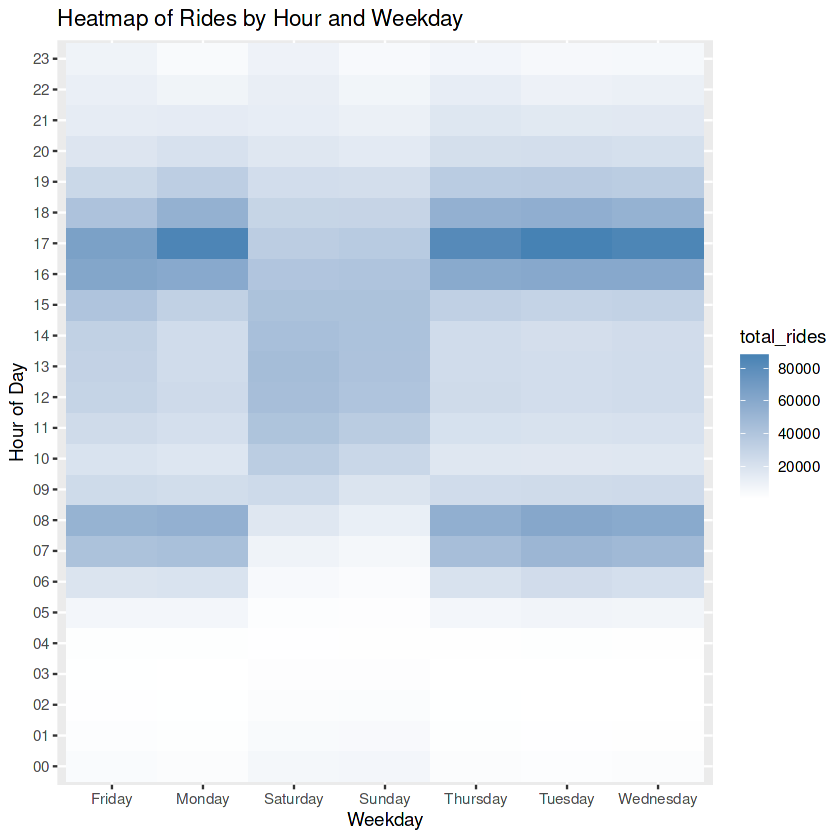

In [39]:
#Heatmap for Hour of Day vs. Weekday
rides_summary <- rides %>%
  group_by(weekday_name, hour_of_day) %>%
  summarise(total_rides = n())
kable(rides_summary)

ggplot(rides_summary, aes(x = weekday_name, y = hour_of_day, fill = total_rides)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "steelblue") +
  labs(title = "Heatmap of Rides by Hour and Weekday",
       x = "Weekday",
       y = "Hour of Day")

**Rides by Holiday**

In [40]:
# Total Rides and Trip Duration Statistics by Holiday Status
rides_by_holiday_and_stats <- rides %>%
  group_by(user_type,holiday_or) %>%
  summarise(
    total_rides = n(),
    min_duration = min(trip_duration, na.rm = TRUE),
    max_duration = max(trip_duration, na.rm = TRUE),
    median_duration = median(trip_duration, na.rm = TRUE),
    mean_duration = mean(trip_duration, na.rm = TRUE),
    stddev_duration = sd(trip_duration, na.rm = TRUE)
  )
kable(rides_by_holiday_and_stats)

`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |holiday_or  | total_rides| min_duration| max_duration| median_duration| mean_duration| stddev_duration|
|:---------|:-----------|-----------:|------------:|------------:|---------------:|-------------:|---------------:|
|casual    |holiday     |       24960|           16|      2241642|          1727.5|     3125.9586|        24292.55|
|casual    |not_holiday |      877228|            2|      9387024|          1540.0|     3564.7173|        59100.67|
|member    |holiday     |       39780|            2|       625452|           605.0|      876.7978|         3942.12|
|member    |not_holiday |     2934086|            1|      9056633|           589.0|      849.3546|        14568.71|

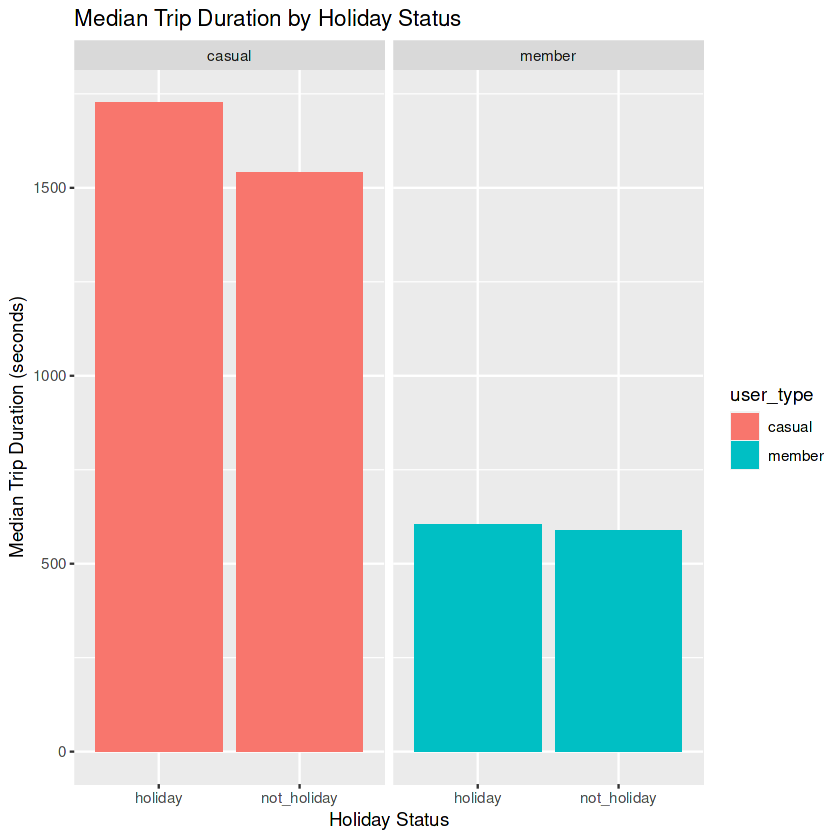

In [41]:
# Plotting Holiday Analysis
ggplot(rides_by_holiday_and_stats, aes(x = holiday_or, y = median_duration, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Median Trip Duration by Holiday Status",
       x = "Holiday Status",
       y = "Median Trip Duration (seconds)") +
  facet_wrap(~ user_type)

In [42]:
# Overall Trend for Holiday Usage
overall_holiday_usage <- rides %>%
  group_by(holiday_or) %>%
  summarise(total_rides = n())
kable(overall_holiday_usage)



|holiday_or  | total_rides|
|:-----------|-----------:|
|holiday     |       64740|
|not_holiday |     3811314|

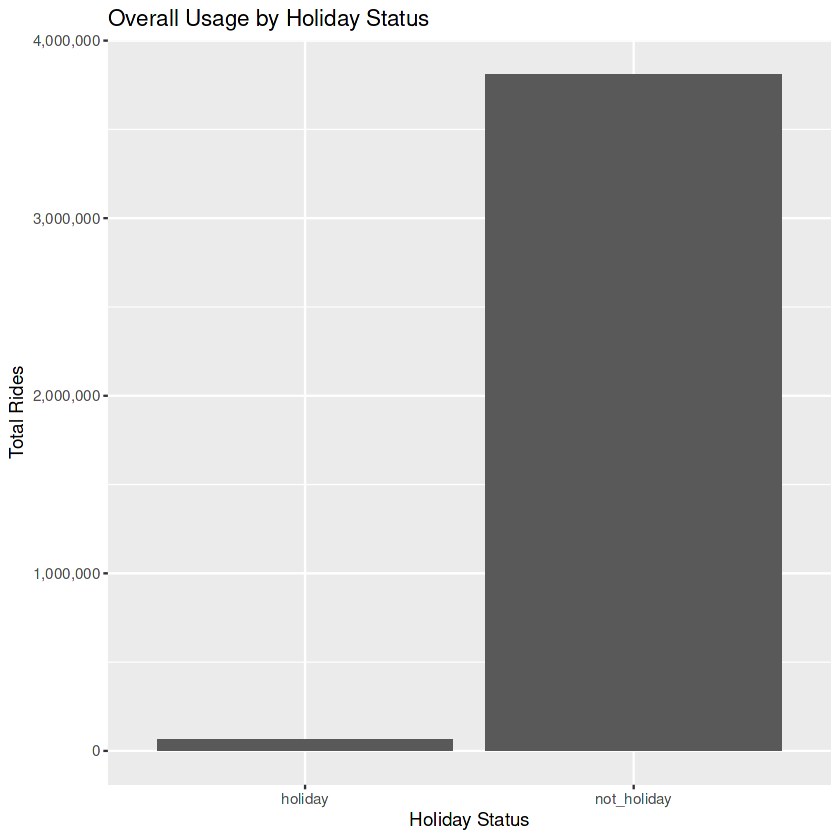

In [43]:
# Plotting the Overall Trend for Holiday Usage
ggplot(overall_holiday_usage, aes(x = holiday_or, y = total_rides)) +
  geom_bar(stat = "identity") +
  labs(title = "Overall Usage by Holiday Status",
       x = "Holiday Status",
       y = "Total Rides") +
  scale_y_continuous(labels = scales::comma)

In [44]:
# Trends by User Type for Holiday Usage
user_holiday_usage <- rides %>%
  group_by(user_type, holiday_or) %>%
  summarise(total_rides = n())
kable(user_holiday_usage)


`summarise()` has grouped output by 'user_type'. You can override using the
`.groups` argument.




|user_type |holiday_or  | total_rides|
|:---------|:-----------|-----------:|
|casual    |holiday     |       24960|
|casual    |not_holiday |      877228|
|member    |holiday     |       39780|
|member    |not_holiday |     2934086|

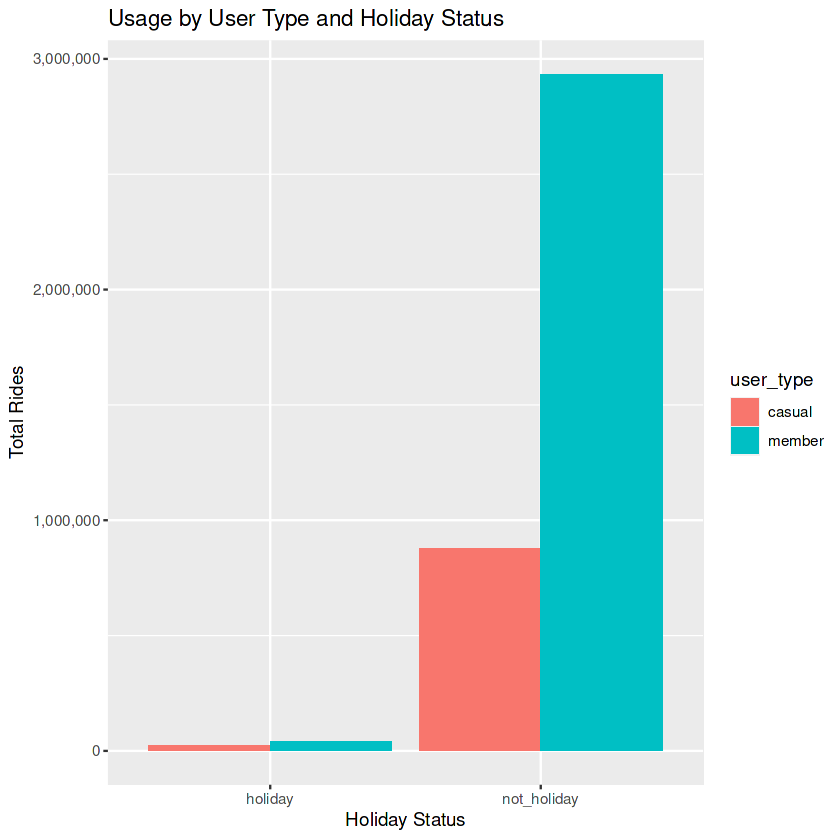

In [45]:
# Plotting the Trends by User Type for Holiday Usage
ggplot(user_holiday_usage, aes(x = holiday_or, y = total_rides, fill = user_type)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Usage by User Type and Holiday Status",
       x = "Holiday Status",
       y = "Total Rides") +
  scale_y_continuous(labels = scales::comma)

In [46]:
#Same station Holiday Analysis
same_station_by_holiday <- rides %>%
  group_by(user_type, holiday_or, return_same_station) %>%
  summarise(total_rides = n())
kable(same_station_by_holiday)

`summarise()` has grouped output by 'user_type', 'holiday_or'. You can override
using the `.groups` argument.




|user_type |holiday_or  |return_same_station | total_rides|
|:---------|:-----------|:-------------------|-----------:|
|casual    |holiday     |No                  |       21558|
|casual    |holiday     |Yes                 |        3402|
|casual    |not_holiday |No                  |      772401|
|casual    |not_holiday |Yes                 |      104827|
|member    |holiday     |No                  |       38696|
|member    |holiday     |Yes                 |        1084|
|member    |not_holiday |No                  |     2881718|
|member    |not_holiday |Yes                 |       52368|

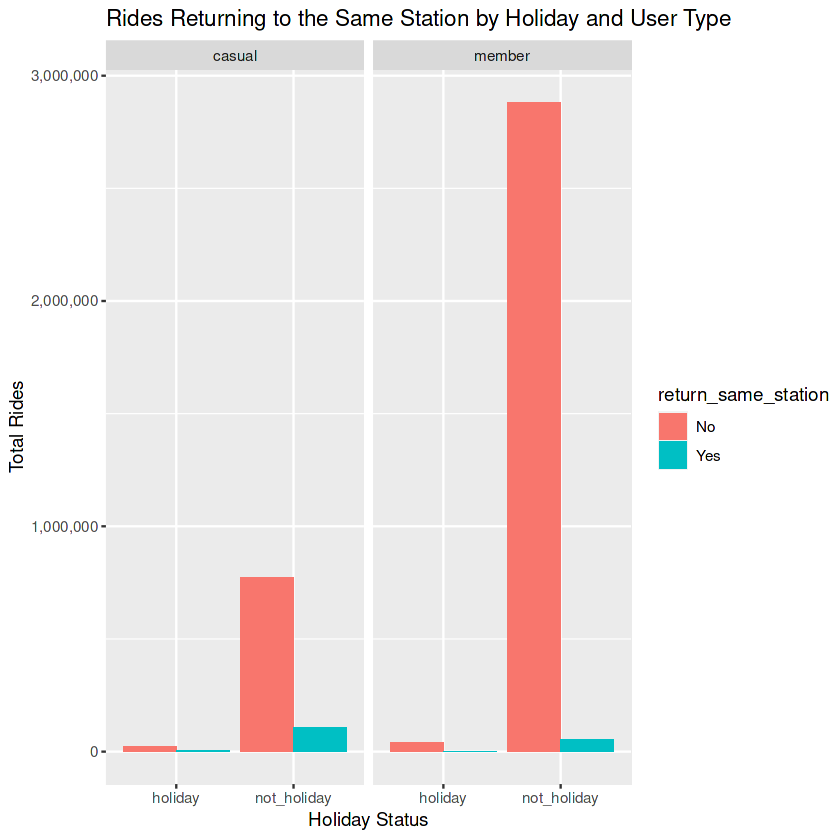

In [47]:
# Plotting the data
ggplot(same_station_by_holiday, aes(x = holiday_or, y = total_rides, fill = return_same_station)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ user_type) +
  labs(title = "Rides Returning to the Same Station by Holiday and User Type",
       x = "Holiday Status",
       y = "Total Rides") +
  scale_y_continuous(labels = scales::comma)

**Conversion Rate**

In [48]:
# Calculate the conversion rate by hour
conversion_rate_by_hour <- rides %>%
  group_by(hour_of_day) %>%
  summarise(
    total_rides = n(),
    casual_rides = sum(user_type == 'casual'),
    conversion_rate = (casual_rides / total_rides) * 100
  ) %>%
  arrange(hour_of_day)
kable(conversion_rate_by_hour)



|hour_of_day | total_rides| casual_rides| conversion_rate|
|:-----------|-----------:|------------:|---------------:|
|00          |       24112|         8363|       34.683975|
|01          |       14475|         5501|       38.003454|
|02          |        8591|         3361|       39.122337|
|03          |        5528|         1982|       35.853835|
|04          |        7882|         1196|       15.173814|
|05          |       37133|         2690|        7.244230|
|06          |      110385|         6291|        5.699144|
|07          |      242904|        13302|        5.476237|
|08          |      310468|        22304|        7.183993|
|09          |      166126|        29057|       17.490941|
|10          |      147662|        45374|       30.728285|
|11          |      183654|        61323|       33.390506|
|12          |      211175|        71626|       33.917841|
|13          |      212642|        77406|       36.402028|
|14          |      211638|        81143|       38.340

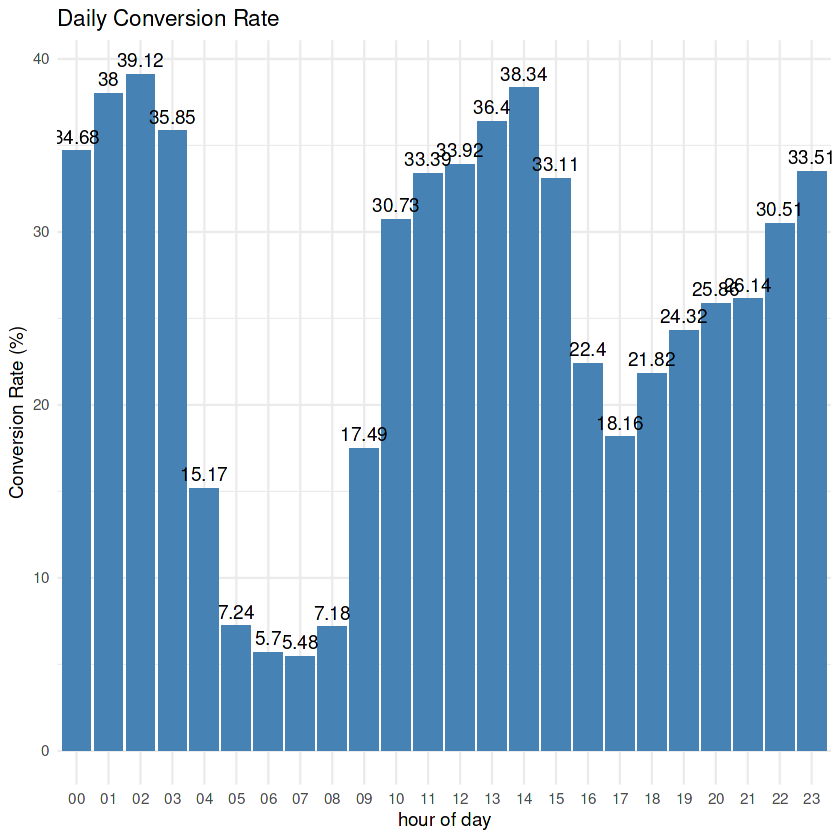

In [49]:
# Plotting the conversion rate by day
ggplot(conversion_rate_by_hour, aes(x = hour_of_day, y = conversion_rate)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = round(conversion_rate, 2)), vjust = -0.5) +
  labs(title = "Daily Conversion Rate",
       x = "hour of day",
       y = "Conversion Rate (%)") +
  theme_minimal()

In [50]:
#Conversion rate by duration
conversion_rate_by_duration <- rides %>%
  group_by(duration_category) %>%
  summarise(
    total_rides = n(),
    casual_rides = sum(user_type == 'casual'),
    conversion_rate = (casual_rides / total_rides) * 100
  ) %>%
  arrange(duration_category)
kable(conversion_rate_by_duration)



|duration_category | total_rides| casual_rides| conversion_rate|
|:-----------------|-----------:|------------:|---------------:|
|0-1 min           |        3908|          189|        4.836233|
|1-5 min           |      529182|        19456|        3.676618|
|5-30 min          |     2801977|       513399|       18.322741|
|30 min - 1 hr     |      379979|       220127|       57.931359|
|1-2 hrs           |      117454|       109038|       92.834642|
|2-6 hrs           |       37003|        35045|       94.708537|
|6-12 hrs          |        2380|         1796|       75.462185|
|12-24 hrs         |        2225|         1631|       73.303371|
|1-7 days          |        1492|         1116|       74.798928|
|7-30 days         |         323|          279|       86.377709|
|> 30 days         |         131|          112|       85.496183|

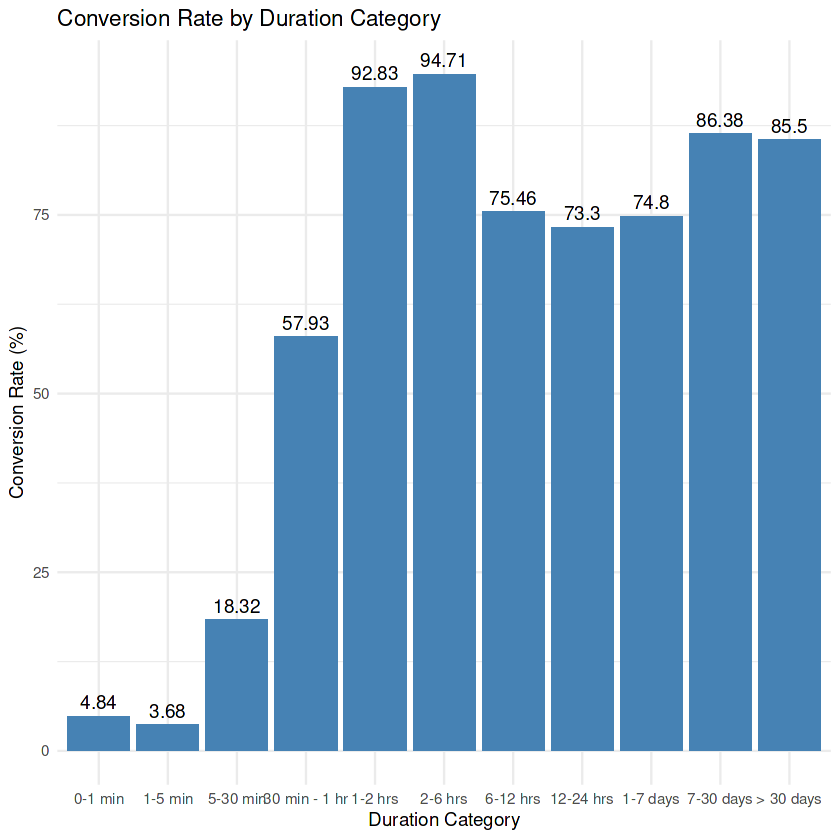

In [51]:
ggplot(conversion_rate_by_duration, aes(x = duration_category, y = conversion_rate)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = round(conversion_rate, 2)), vjust = -0.5) +
  labs(title = "Conversion Rate by Duration Category",
       x = "Duration Category",
       y = "Conversion Rate (%)") +
  theme_minimal()


In [52]:
#Conversion Rate by weekday
conversion_rate_by_weekday <- rides %>%
  group_by(weekday_name) %>%
  summarise(
    total_rides = n(),
    casual_rides = sum(user_type == 'casual'),
    conversion_rate = (casual_rides / total_rides) * 100
  ) %>%
  arrange(weekday_name)
kable(conversion_rate_by_weekday)



|weekday_name | total_rides| casual_rides| conversion_rate|
|:------------|-----------:|------------:|---------------:|
|Friday       |      575194|       122404|        21.28047|
|Monday       |      575492|       103296|        17.94916|
|Saturday     |      497501|       209543|        42.11911|
|Sunday       |      449270|       181299|        40.35413|
|Thursday     |      586856|       102679|        17.49646|
|Tuesday      |      598955|        90510|        15.11132|
|Wednesday    |      592786|        92457|        15.59703|

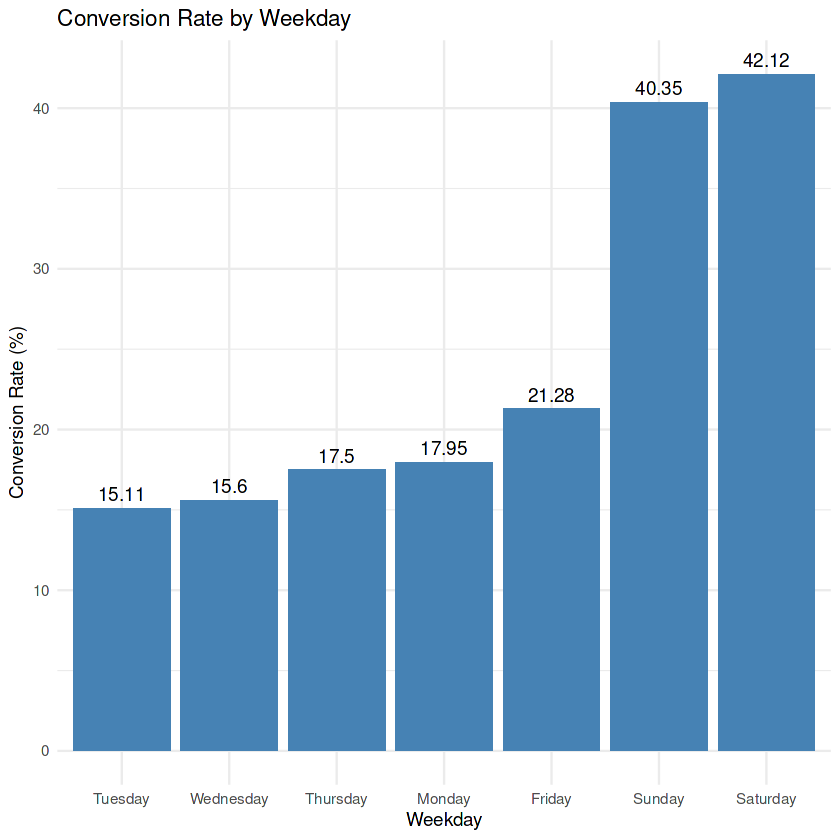

In [53]:
ggplot(conversion_rate_by_weekday, aes(x = reorder(weekday_name, conversion_rate), y = conversion_rate)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = round(conversion_rate, 2)), vjust = -0.5) +
  labs(title = "Conversion Rate by Weekday",
       x = "Weekday",
       y = "Conversion Rate (%)") +
  theme_minimal()

In [54]:
#conversion rate by season
conversion_rate_by_season <- rides %>%
  group_by(season) %>%
  summarise(
    total_rides = n(),
    casual_rides = sum(user_type == 'casual'),
    conversion_rate = (casual_rides / total_rides) * 100
  ) %>%
  arrange(season)
kable(conversion_rate_by_season)



|season | total_rides| casual_rides| conversion_rate|
|:------|-----------:|------------:|---------------:|
|Fall   |     1042181|       218937|       21.007579|
|Spring |      772975|       153983|       19.920825|
|Summer |     1622894|       492739|       30.361749|
|Winter |      438004|        36529|        8.339878|

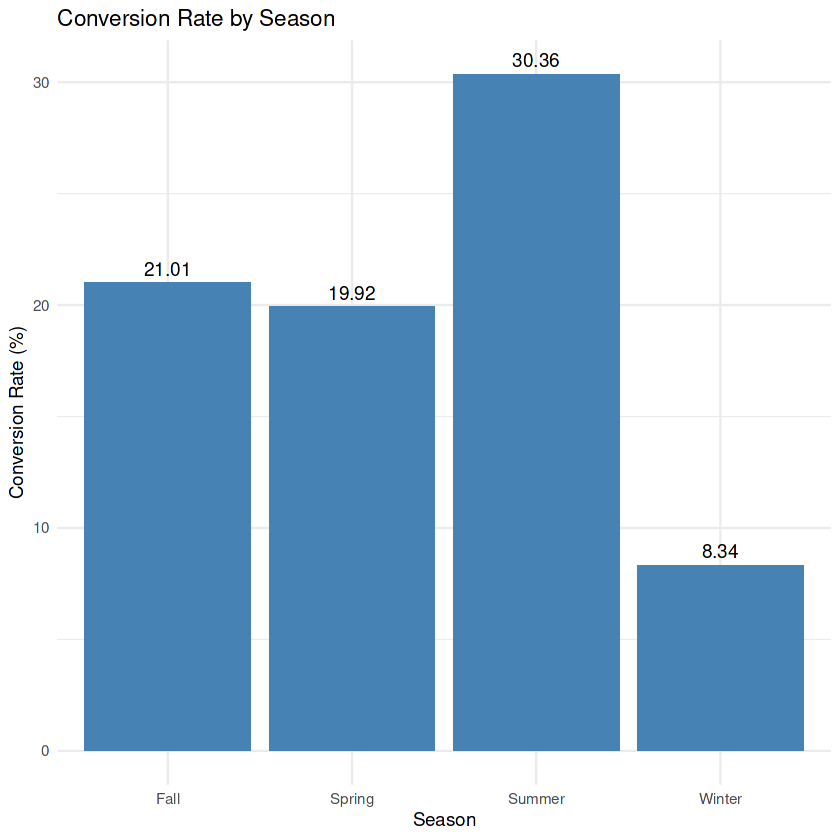

In [55]:
ggplot(conversion_rate_by_season, aes(x = season, y = conversion_rate)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = round(conversion_rate, 2)), vjust = -0.5) +
  labs(title = "Conversion Rate by Season",
       x = "Season",
       y = "Conversion Rate (%)") +
  theme_minimal()

In [56]:
#Converstion Rate by weekend
conversion_rate_by_day_type <- rides %>%
  group_by(weekend_or) %>%
  summarise(
    total_rides = n(),
    casual_rides = sum(user_type == 'casual'),
    conversion_rate = (casual_rides / total_rides) * 100
  ) %>%
  arrange(weekend_or)
kable(conversion_rate_by_day_type)



|weekend_or | total_rides| casual_rides| conversion_rate|
|:----------|-----------:|------------:|---------------:|
|weekday    |     2929283|       511346|        17.45635|
|weekend    |      946771|       390842|        41.28158|

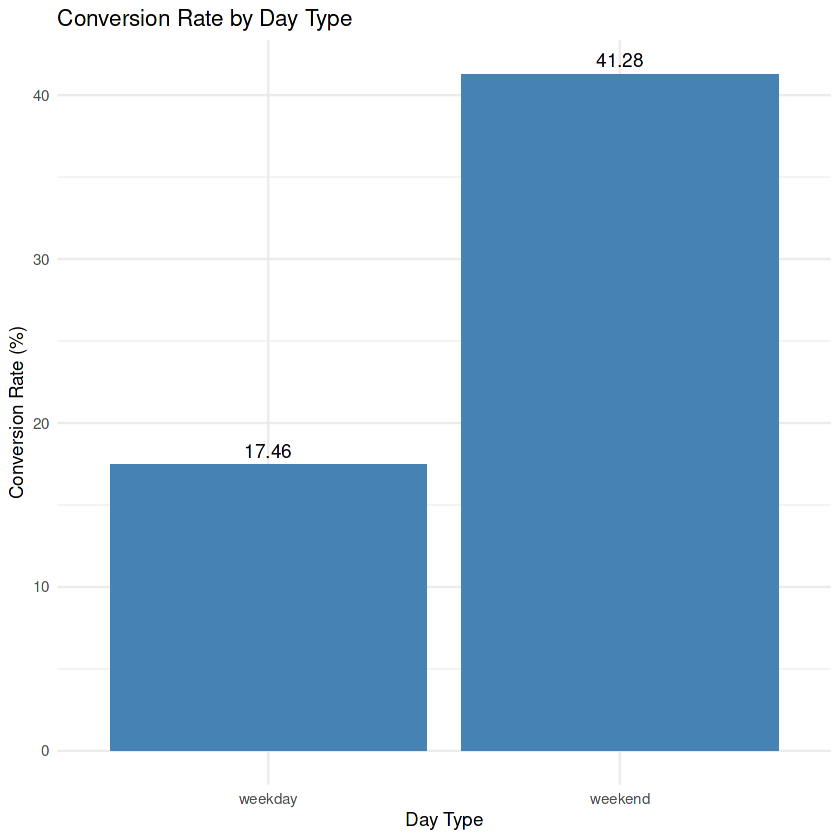

In [57]:
ggplot(conversion_rate_by_day_type, aes(x = weekend_or, y = conversion_rate)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = round(conversion_rate, 2)), vjust = -0.5) +
  labs(title = "Conversion Rate by Day Type",
       x = "Day Type",
       y = "Conversion Rate (%)") +
  theme_minimal()

In [58]:
#Conversion Rate by Holiday
conversion_rate_by_holiday <- rides %>%
  group_by(holiday_or) %>%
  summarise(
    total_rides = n(),
    casual_rides = sum(user_type == 'casual'),
    conversion_rate = (casual_rides / total_rides) * 100
  ) %>%
  arrange(holiday_or)
kable(conversion_rate_by_holiday)



|holiday_or  | total_rides| casual_rides| conversion_rate|
|:-----------|-----------:|------------:|---------------:|
|holiday     |       64740|        24960|        38.55422|
|not_holiday |     3811314|       877228|        23.01642|

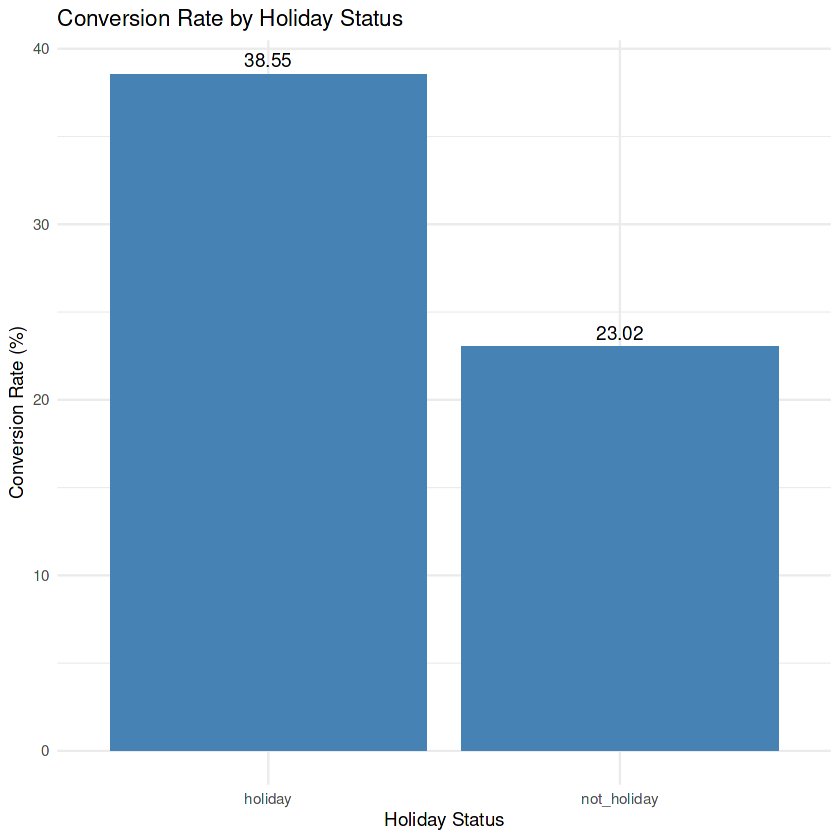

In [59]:
ggplot(conversion_rate_by_holiday, aes(x = holiday_or, y = conversion_rate)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = round(conversion_rate, 2)), vjust = -0.5) +
  labs(title = "Conversion Rate by Holiday Status",
       x = "Holiday Status",
       y = "Conversion Rate (%)") +
  theme_minimal()

**General Overview:**

The dataset contains a total of 3,866,054 rides, providing a rich source of information for detailed analysis.

Instead of the average, the median was used for most calculations to minimize the impact of outliers. The median duration for all rides is approximately 643 seconds, which translates to roughly 10.7 minutes.

Overview by User Type (Casual vs. Member):

Casual Users
Total Rides: 902,188
Median Duration: 1,597 seconds (approx. 26.6 minutes)

Member Users
Total Rides: 2,963,866
Median Duration: 567 seconds (approx. 9.45 minutes)

Preliminary observations suggest that casual users generally have fewer but longer rides, whereas members tend to have more frequent but shorter rides.

Temporal Analysis:

The temporal analysis section focuses on how ride-sharing behaviors change over time, considering various factors like seasons, weekdays vs weekends, peak hours, and holidays. By understanding these patterns, businesses can make informed decisions on resource allocation, marketing strategies, and customer engagement.




**Seasonal Trends:**

Rides by Season

The dataset shows distinct seasonal trends in ride-sharing behavior:

Fall: 1,042,181 total rides
Spring: 772,975 total rides
Summer: 1,622,894 total rides
Winter: 438,004 total rides

Summer appears to be the most popular season for ride-sharing, followed by Fall, Spring, and Winter.
Seasonal Behavior by User Type

Casual Users:
Most active during Summer with 492,739 rides
Least active during Winter with 36,529 rides

Member Users:
Most active during Summer with 1,130,155 rides
Least active during Winter with 401,475 rides




**Weekday vs Weekend:**

Overall Weekday vs Weekend Usage:

Weekday: 2,929,283 total rides
Weekend: 946,771 total rides

Ride-sharing is more prevalent on weekdays.

User-Specific Weekday vs Weekend Trends:

Casual Users:
Weekday: 511,346 rides
Weekend: 390,842 rides

Member Users:
Weekday: 2,417,937 rides
Weekend: 555,929 rides

Peak Usage Times:

The dataset records rides for each hour of the day, allowing us to identify peak usage times:

Most Active Hour: 17:00 (5 PM) with 478,086 total rides
Least Active Hour: 03:00 (3 AM) with 5,528 total rides




**Holiday Analysis:**

Overall Holiday Usage:

Holiday: 64,740 total rides
Non-Holiday: 3,811,314 total rides

Ride-sharing is significantly less frequent on holidays.

User-Specific Holiday Trends:

Casual Users:

Holiday: 24,960 rides
Non-Holiday: 877,228 rides

Member Users:

Holiday: 39,780 rides
Non-Holiday: 2,934,086 rides




**Hourly Patterns:**

Understanding the hourly patterns in ride-sharing behavior allows for better strategic planning and resource allocation. This part of the analysis focuses on when ride-sharing is most and least popular within a day and how different user types behave in these contexts.

Overall Peak Hours:

Examining the dataset allows us to identify the peak usage times for ride-sharing:

Most Active Hour: 17:00 (5 PM) with 478,086 total rides
Least Active Hour: 03:00 (3 AM) with 5,528 total rides

Hourly User Behavior:

Casual Users: Most active during the late afternoon and early evening, peaking at 17:00 (5 PM).
Member Users: Activity is highest during the morning and late afternoon, corresponding to typical commuting times.


General Duration Stats:

Minimum Duration: 1 minute
Maximum Duration: Over 30 days (some outliers present)
Median Duration: 650 seconds (for member users during Summer), 1598 seconds (for casual users during Summer)

Duration by User Type:

Casual Users: Median duration is highest during Spring with 1657 seconds.
Member Users: Median duration is highest during Summer with 650 seconds.

Duration Categories:

The dataset categorizes the duration of rides, giving further insights into user behavior:

0-1 min: 3,908 rides
1-5 min: 529,182 rides
5-30 min: 2,801,977 rides
30 min - 1 hr: 379,979 rides
1-2 hrs: 117,454 rides
2-6 hrs: 37,003 rides
6-12 hrs: 2,380 rides
12-24 hrs: 2,225 rides
1-7 days: 1,492 rides
7-30 days: 323 rides
30 days: 131 rides

Most rides fall within the 5-30 minute range, indicating that the service is primarily used for short, quick trips in general.





**Station-Specific Insights:**

Analyzing the behavior of users in relation to station usage can provide valuable insights into how well the ride-sharing service is serving its customer base. It can also offer data-driven avenues for operational improvements. In this section, we will delve into the patterns associated with users who start and end their rides at the same station.

Same Station by User Type:
Casual Users: A smaller proportion return to the same station (roughly 20,827 rides).
Member Users: An even smaller proportion return to the same station (around 11,681 rides).
Casual users are slightly more likely than member users to return to the same station. This could be indicative of casual users taking leisure, exploratory rides.

Same Station by Season:

Fall: Casual (21,126), Member (11,681)
Spring: Casual (22,395), Member (13,079)
Summer: Casual (60,422), Member (21,682)
Winter: Casual (4,286), Member (7,010)

The propensity to return to the same station is season-dependent. Both user types are more likely to end at the same station in the summer, possibly due to leisurely or recreational rides.

Same Station by Holiday:

Holiday: Casual (3,402), Member (1,084)
Not Holiday: Casual (104,827), Member (52,368)

During holidays, both casual and member users are less likely to return to the same station. This could be due to the fact that holidays are often spent going from one place to another, rather than looping back to the starting point.
Also, Casual riders are 3 times likely to return the bike to the same station during holidays against Member rides, compared to 2 times likely during Non Holidays.

Same Station by Hour:

Peak Hours: Lower incidence of same-station returns.
Off-Peak Hours: Higher incidence of same-station returns.

During peak hours, riders are often commuting to specific destinations and therefore are less likely to return to the same station. During off-peak hours, users may be more exploratory, leading to higher rates of return to the same station.

Same Station by Weekday:

Weekdays: Casual (59,913), Member (36,907)
Weekends: Casual (48,316), Member (16,545)

Weekdays see a higher number of same-station rides for both user types, potentially due to the nature of weekday activities, such as errands that start and end at home.






**Conversion Analysis:**

The concept of "conversion" in the context of this ride-sharing analysis refers to the percentage of casual users who become member users. Understanding conversion rates provides valuable insights into user behavior, loyalty, and the overall effectiveness of the service in retaining customers. Higher conversion rates can signify a strong value proposition and customer satisfaction, while lower rates might indicate areas for improvement.

What is Conversion Rate?:

The conversion rate is calculated as the number of casual users who become member users divided by the total number of casual users, multiplied by 100. It helps us understand the efficiency of converting casual one-time users into long-term committed members.
Conversion Rate=(Number of Casual Users converted to MembersTotal Number of Casual Users)×100Conversion Rate=(Total Number of Casual UsersNumber of Casual Users converted to Members​)×100

Conversion by Day Type (Weekday/Weekend):

Weekday: 17.5%
Weekend: 41.3%

The conversion rate is significantly higher during weekends. This suggests that casual users are more likely to convert to members during weekends, possibly due to more free time to explore the service.

Conversion by Holiday:

Holiday: 38.6%
Not Holiday: 23.0%

Interestingly, holidays seem to be an effective period for converting casual users, possibly because people have more leisure time to engage with the service.

Conversion by Duration:

Shortest rides (0-1 min): 4.84%
Longest rides (>30 days): 85.5%

The conversion rate is remarkably high for extremely long-duration rides. This could be indicative of a strong commitment to the service, but it also may be an outlier that needs further investigation.

Conversion by Season:

Fall: 21.0%
Spring: 19.9%
Summer: 30.4%
Winter: 8.34%

Summer has the highest conversion rate, due to the favorable weather conditions making ride-sharing more appealing. Winter shows the lowest rate, due to adverse weather conditions discouraging casual users.

Conversion by Hour:

Highest: 02:00 (3 AM) with a rate of 39.1%
Lowest: 05:00 (5 AM) with a rate of 7.24%


Conversion by Weekday:

Highest: Saturday with 42.1%
Lowest: Tuesday with 15.1%

Weekends, particularly Saturdays, seem to be the most effective days for converting casual users into members.





**Summary and Key Takeaways:**

After an exhaustive analysis of ride-sharing data, we have unearthed several key insights that can inform both operational and strategic decision-making for the company.

Most and Least Active Times:

Most Active Times: Peak hours during weekdays, especially in the morning and late afternoon. Summer also sees higher activity.
Least Active Times: Winter months and late-night hours.

Target promotions during off-peak hours and seasons to increase user engagement. Also, consider resource allocation strategies to meet demand during peak times.

User Preferences:

Casual Users: Prefer weekends and are more likely to take longer, exploratory rides. More active during summer.
Member Users: More active on weekdays, likely for commuting. Prefer shorter, more purposeful rides.

Tailor marketing campaigns and promotions to meet the specific needs and preferences of these two distinct user groups. For example, offer weekend adventure packages for casual users and commuter discount cards for members.

Seasonal and Holiday Trends:

High Season: Summer
Low Season: Winter

Holiday Usage: Generally lower, especially for members.

Use these insights to craft season-specific campaigns and perhaps offer special holiday packages to boost rides during these typically slower periods.

Conversion Rates:

Higher on weekends and holidays for casual users.
Lower conversion rates during peak weekday hours, suggesting that the service is primarily used for commuting rather than leisure rides during these times.
Key Takeaway: Aim to convert more casual riders into members by targeting them during high-conversion periods like weekends and holidays.

Station-Specific Insights:

Both types of users are more likely to return to the same station during off-peak hours and on weekends.
Key Takeaway: This information could be useful for station placement and local area marketing. Stations with high same-station returns could be marketed as ideal starting points for leisurely rides or short errands.




**Suggestions for Business Strategies:**

Targeted Promotions: Use data on user preferences and activity levels to create targeted marketing campaigns.

Resource Allocation: Match supply with demand by allocating more resources during peak hours and high-activity seasons.

User Retention: Focus on converting casual users to members, especially during high conversion periods like weekends.
Seasonal and Holiday Packages: Offer special deals during low-activity seasons and holidays to attract more riders.

Local Area Marketing: Use station-specific data to implement local marketing strategies.